In [1]:
# machine learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm

# Visualization of data
import matplotlib.pyplot as plt

import os
import mne
import math

import numpy as np

# Connects to the database
import mysql.connector

# Getting data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.).pick_types(meg='mag', eeg=False, stim=True, eog=True)
raw.load_data()

# Clean data
Clean_raw = mne.io.read_raw_fif("Clean_raw.fif")
Clean_raw.load_data()

Opening raw data file C:\Users\shamd\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading 0 ... 9009  =      0.000 ...    59.999 secs...
Opening raw data file Clean_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | Clean_raw.fif, 102 x 9010 (60.0 s), ~10.0 MB, data loaded>

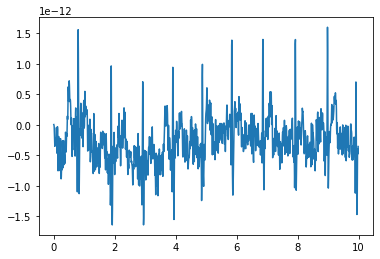

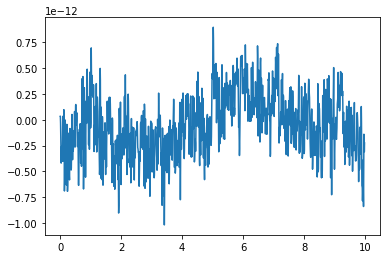

In [4]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 10])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
raw_selection = raw['MEG 1431', start_sample:stop_sample]
Clean_raw_selection = Clean_raw['MEG 1431', start_sample:stop_sample]

n_x = raw_selection[1]   # time
n_y = raw_selection[0].T # data array transposed
n_x = n_x[:1500:]
n_y = n_y[:1500:]
plt.plot(n_x, n_y)
plt.show()
# Plotting Clean signal (Orange)
c_x = Clean_raw_selection[1]
c_y = Clean_raw_selection[0].T
c_x = c_x[:1500:]
c_y = c_y[:1500:]
plt.plot(c_x, c_y)
plt.show()

In [81]:
noise = n_y - c_y
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(c_y)**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

-1.0275490533153533


In [8]:
noise = noisy_input[0] - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

12.039903553490108


In [33]:
scale = np.max(n_y) - np.min(n_y)
unnormal = (noisy_input[0] * scale) + np.min(n_y)
print(unnormal - n_y)
print("\n")
print(n_y)

[[5.04870979e-29]
 [0.00000000e+00]
 [0.00000000e+00]
 ...
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]


[[ 3.08119417e-15]
 [-7.69707315e-15]
 [-3.85216091e-14]
 ...
 [-3.94486624e-13]
 [-4.77683544e-13]
 [-3.57082253e-13]]


1/1 [==============================] - 1s 876ms/step


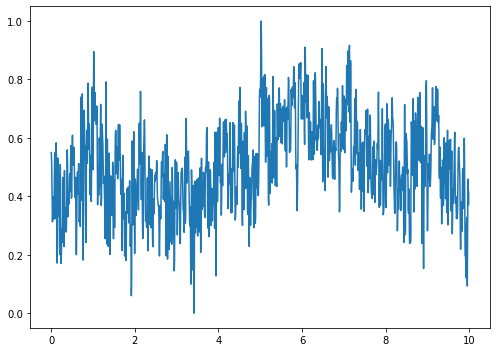

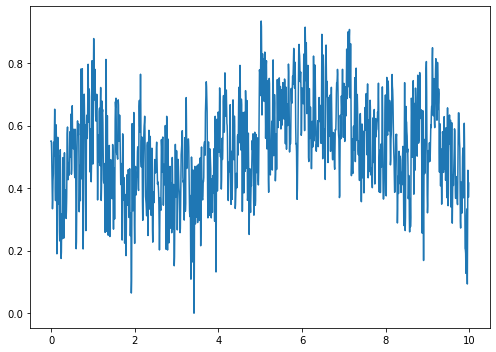

In [5]:
train_test_split = 0.3
validation_split = 0.3

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

# Generate reconstructions
num_reconstructions = 1
samples = noisy_input_test[:num_reconstructions]
reconstructions = loaded_model.predict(samples)

# Plot reconstructions
for i in np.arange(0, num_reconstructions):
    # Prediction index
    prediction_index = i + percentage_training
    # Get the sample and the reconstruction
    original = y_val_noisy_r[prediction_index]
    pure = y_val_pure_r[prediction_index]
    reconstruction = np.array(reconstructions[i])
    # Matplotlib preparations
    #fig, axes = plt.subplots(1, 3)
    # Plot sample and reconstruciton
    plt.rcParams["figure.figsize"] = (7,5)
    plt.plot(c_x,pure)
    plt.tight_layout()
    plt.show()
    plt.rcParams["figure.figsize"] = (7,5)
    plt.plot(c_x, reconstruction)
    plt.tight_layout()
    plt.show()

In [9]:
noise = reconstruction - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

22.663452021807238


In [4]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer='adam', loss='binary_crossentropy')

Loaded model from disk


In [19]:
noise = noisy_input[0] - pure_input[0]

r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

12.039903553490108


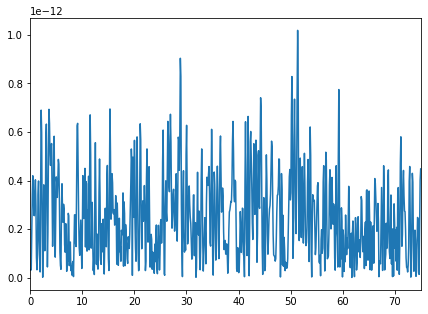

In [23]:
z = fft(c_y)
#b = math.sqrt(z*np.conj(z))
size = len(n_y)
a = abs(z) # magnitude
f = fftfreq(size, 1/sampling_freq)[:size//2]
plt.plot(f,a[0:size//2])
plt.xlim(0,sampling_freq//2)
plt.show()

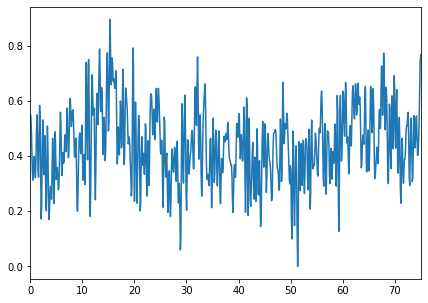

In [24]:
from scipy.fft import fft, fftfreq
z = fft(pure_input[0])
#b = math.sqrt(z*np.conj(z))
size = len(noisy_input[0])
a = abs(z) # magnitude
f = fftfreq(size, 1/sampling_freq)[:size//2]
plt.plot(f,a[0:size//2])
plt.xlim(0,sampling_freq//2)
plt.show()

In [2]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 10])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
raw_selection = raw['MEG 1431', start_sample:stop_sample]
Clean_raw_selection = Clean_raw['MEG 1431', start_sample:stop_sample]

n_x = raw_selection[1]   # time
n_y = raw_selection[0].T # data array transposed
n_x = n_x[:1500:]
n_y = n_y[:1500:]
# Plotting Clean signal (Orange)
c_x = Clean_raw_selection[1]
c_y = Clean_raw_selection[0].T
c_x = c_x[:1500:]
c_y = c_y[:1500:]

num_of_samples = 30000
# Containers for samples.
n_samples = []
c_samples = []
x_s = [] # array of x values
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,len(n_y)):
        x_s.append(n_x[i])
        y_s.append(n_y[i][0])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    for k in range(0,len(n_y)):
        x_s.append(c_x[k])
        y_s.append(c_y[k][0])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array

In [3]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  

Going to next computations...



In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Model Configuration
input_shape = (1500,1)
batch_size = 120
no_epochs = 20
train_test_split = 0.3
validation_split = 0.3
verbosity = 1
max_norm_value = 2.0

callback = EarlyStopping(monitor='val_loss', patience = 2)

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer='adam', loss='binary_crossentropy')
callback = EarlyStopping(monitor='val_loss', patience = 2)
result = loaded_model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                callbacks = [callback],
                validation_split=validation_split)

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

Loaded model from disk
Epoch 1/20
175/175 [==============================] - 316s 2s/step - loss: 0.6602 - val_loss: 0.6495
Epoch 2/20
175/175 [==============================] - 317s 2s/step - loss: 0.6491 - val_loss: 0.6484
Epoch 3/20
175/175 [==============================] - 325s 2s/step - loss: 0.6484 - val_loss: 0.6480
Epoch 4/20
175/175 [==============================] - 310s 2s/step - loss: 0.6481 - val_loss: 0.6477
Epoch 5/20
175/175 [==============================] - 299s 2s/step - loss: 0.6478 - val_loss: 0.6476
Epoch 6/20
175/175 [==============================] - 309s 2s/step - loss: 0.6475 - val_loss: 0.6472
Epoch 7/20
175/175 [==============================] - 321s 2s/step - loss: 0.6472 - val_loss: 0.6474
Epoch 8/20
175/175 [==============================] - 313s 2s/step - loss: 0.6470 - val_loss: 0.6466
Epoch 9/20
175/175 [==============================] - 306s 2s/step - loss: 0.6467 - val_loss: 0.6467
Epoch 10/20
175/175 [==============================] - 316s 2s/step 

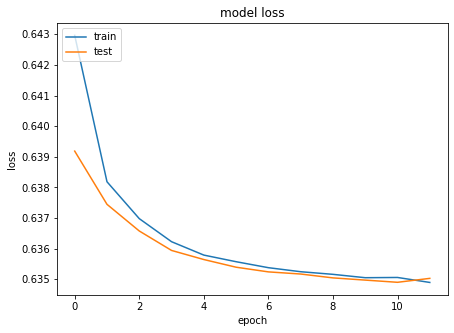

In [43]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
train_test_split = 0.3
validation_split = 0.3
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

1/1 [==============================] - 0s 25ms/step


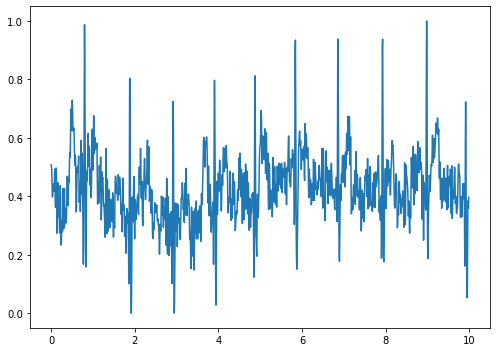

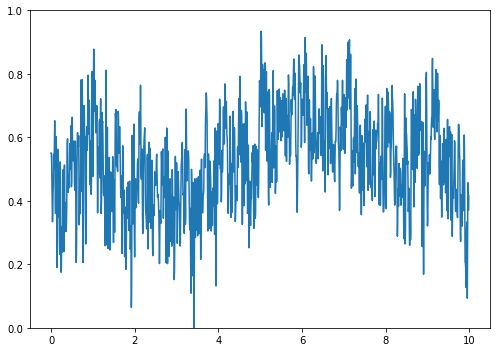

In [10]:
# Generate reconstructions
num_reconstructions = 1
samples = noisy_input_test[:num_reconstructions]
reconstructions = loaded_model.predict(samples)

# Plot reconstructions
for i in np.arange(0, num_reconstructions):
    # Prediction index
    prediction_index = i + percentage_training
    # Get the sample and the reconstruction
    original = y_val_noisy_r[prediction_index]
    pure = y_val_pure_r[prediction_index]
    reconstruction = np.array(reconstructions[i])
    # Matplotlib preparations
    #fig, axes = plt.subplots(1, 3)
    # Plot sample and reconstruciton
    plt.rcParams["figure.figsize"] = (7,5)
    plt.plot(c_x,original)
    #axes[0].plot(original)
    #axes[1].plot(pure)
    #axes[2].plot(reconstruction)
    plt.tight_layout()
    plt.show()
    plt.rcParams["figure.figsize"] = (7,5)
    plt.plot(c_x, reconstruction)
    plt.ylim(0.0,1.0)
    plt.tight_layout()
    plt.show()

In [22]:
scale = np.max(c_y) - np.min(c_y)
unnormal = (reconstruction * scale) + np.min(c_y)
print(unnormal)
print("\n")
print(c_y)
noise = unnormal - c_y
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(c_y)**2)
SNR = 10 * math.log10(signal/r)
print("\n")
print(SNR)

[[ 3.4825441e-14]
 [ 3.5111887e-14]
 [-2.3571748e-14]
 ...
 [-1.6429647e-13]
 [-3.0911124e-13]
 [-2.2189227e-13]]


[[ 3.32879439e-14]
 [ 3.13128621e-14]
 [-3.32067338e-14]
 ...
 [-1.68584673e-13]
 [-3.09888359e-13]
 [-2.24975587e-13]]


12.056275400596164


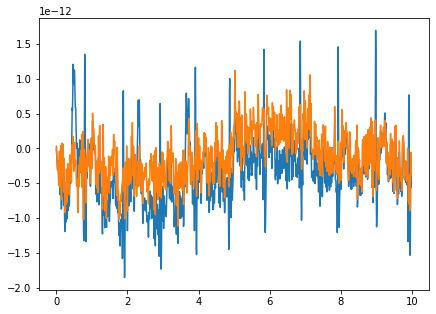

In [38]:
raw_selection = raw['MEG 1421', start_sample:stop_sample]
Clean_raw_selection = Clean_raw['MEG 1421', start_sample:stop_sample]

n_x = raw_selection[1]   # time
n_y = raw_selection[0].T # data array transposed
n_x = n_x[:1500:]
n_y = n_y[:1500:]
plt.plot(n_x, n_y)
# Plotting Clean signal (Orange)
c_x = Clean_raw_selection[1]
c_y = Clean_raw_selection[0].T
c_x = c_x[:1500:]
c_y = c_y[:1500:]
plt.plot(c_x, c_y)

num_of_samples = 30000
# Containers for samples.
n_samples = []
c_samples = []
x_s = [] # array of x values
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,len(n_y)):
        x_s.append(n_x[i])
        y_s.append(n_y[i][0])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    for k in range(0,len(n_y)):
        x_s.append(c_x[k])
        y_s.append(c_y[k][0])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array

In [41]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  

Going to next computations...



(30000, 1500, 1)


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 120
no_epochs = 20

callback = EarlyStopping(monitor='val_loss', patience = 1)

result = loaded_model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                callbacks = [callback],
                validation_split=validation_split)

Epoch 1/20
175/175 [==============================] - 318s 2s/step - loss: 0.6430 - val_loss: 0.6392
Epoch 2/20
175/175 [==============================] - 323s 2s/step - loss: 0.6382 - val_loss: 0.6374
Epoch 3/20
175/175 [==============================] - 330s 2s/step - loss: 0.6370 - val_loss: 0.6366
Epoch 4/20
175/175 [==============================] - 317s 2s/step - loss: 0.6362 - val_loss: 0.6359
Epoch 5/20
175/175 [==============================] - 299s 2s/step - loss: 0.6358 - val_loss: 0.6356
Epoch 6/20
175/175 [==============================] - 295s 2s/step - loss: 0.6356 - val_loss: 0.6354
Epoch 7/20
175/175 [==============================] - 313s 2s/step - loss: 0.6354 - val_loss: 0.6352
Epoch 8/20
175/175 [==============================] - 322s 2s/step - loss: 0.6352 - val_loss: 0.6352
Epoch 9/20
175/175 [==============================] - 321s 2s/step - loss: 0.6352 - val_loss: 0.6350
Epoch 10/20
175/175 [==============================] - 325s 2s/step - loss: 0.6351 - val_lo

In [54]:
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

In [ ]:
import mysql.connector
# Connecting to the Database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
)

mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE IF NOT EXISTS Biomedical")

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="Biomedical"
)

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS Signals (ynoise DOUBLE(31,30), yclean DOUBLE(31,30), yrec FLOAT(9,8))")

recarray = np.ravel(reconstruction).tolist()
for i in range(0,len(y_val_noisy[0])):
    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"
    valone = y_val_noisy[0][i]
    valtwo = y_val_pure[0][i]
    valthree = recarray[i]
    val = [(valone,valtwo,valthree)]
    mycursor.executemany(sql, val)
    mydb.commit()

In [40]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
